# [Plant Seedlings Classification](https://www.kaggle.com/competitions/plant-seedlings-classification/code)


In [7]:
from os import cpu_count, listdir, path
from pathlib import Path
from random import choice, seed
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from torch import Tensor
from torch.utils.data import DataLoader


## Global Variables


In [8]:
# Metal Performance Shaders (MPS) - Apple Metal GPU acceleration
def get_mps_device() -> torch.device:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        x = torch.ones(1, device=device)
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        x = torch.ones(1, device=device)
    else:
        device = torch.device("cpu")
    return device


DEVICE = get_mps_device()

DATA_ROOT = Path("./data")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"

RANDOM_SEED = 42
BATCH_SIZE = 64

print(f"Torch version: {torch.__version__}")
print(f"CPU cores: {cpu_count()}")

print(f"DEVICE: {DEVICE}")
print(f"DATA_ROOT: {DATA_ROOT}")
print("Random seed:", RANDOM_SEED)
print("Batch size:", BATCH_SIZE)

print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

Torch version: 2.6.0
CPU cores: 14
DEVICE: mps
DATA_ROOT: data
Random seed: 42
Batch size: 64
MPS available: True
MPS built: True


## Reproducibility


In [9]:
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Loading


In [10]:
transform_resize = (224, 224)

transform = transforms.Compose(
    [
        transforms.Resize(transform_resize),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

In [11]:
transform = transforms.Compose(
    [
        transforms.Resize(size=transform_resize),
        transforms.RandomResizedCrop(
            size=transform_resize, scale=(0.8, 1.0), ratio=(0.9, 1.1)
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=360),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=None)

len_dataset = len(dataset)
num_classes = len(dataset.classes)
print(f"Dataset length: {len_dataset}")
print(f"Dataset classes ({num_classes}): {dataset.classes}")

Dataset length: 4750
Dataset classes (12): ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Class Distribution


In [12]:
label_counts = {}
for label in listdir(TRAIN_DIR):
    label_path = path.join(TRAIN_DIR, label)

    if path.isdir(label_path):
        num_files = len(
            [f for f in listdir(label_path) if path.isfile(path.join(label_path, f))]
        )
        label_counts[label] = num_files

fig = px.bar(
    x=list(label_counts.keys()),
    y=list(label_counts.values()),
    title="Class Distribution",
    labels={"x": "Class", "y": "Count"},
).update_xaxes(categoryorder="total descending")
fig.show()

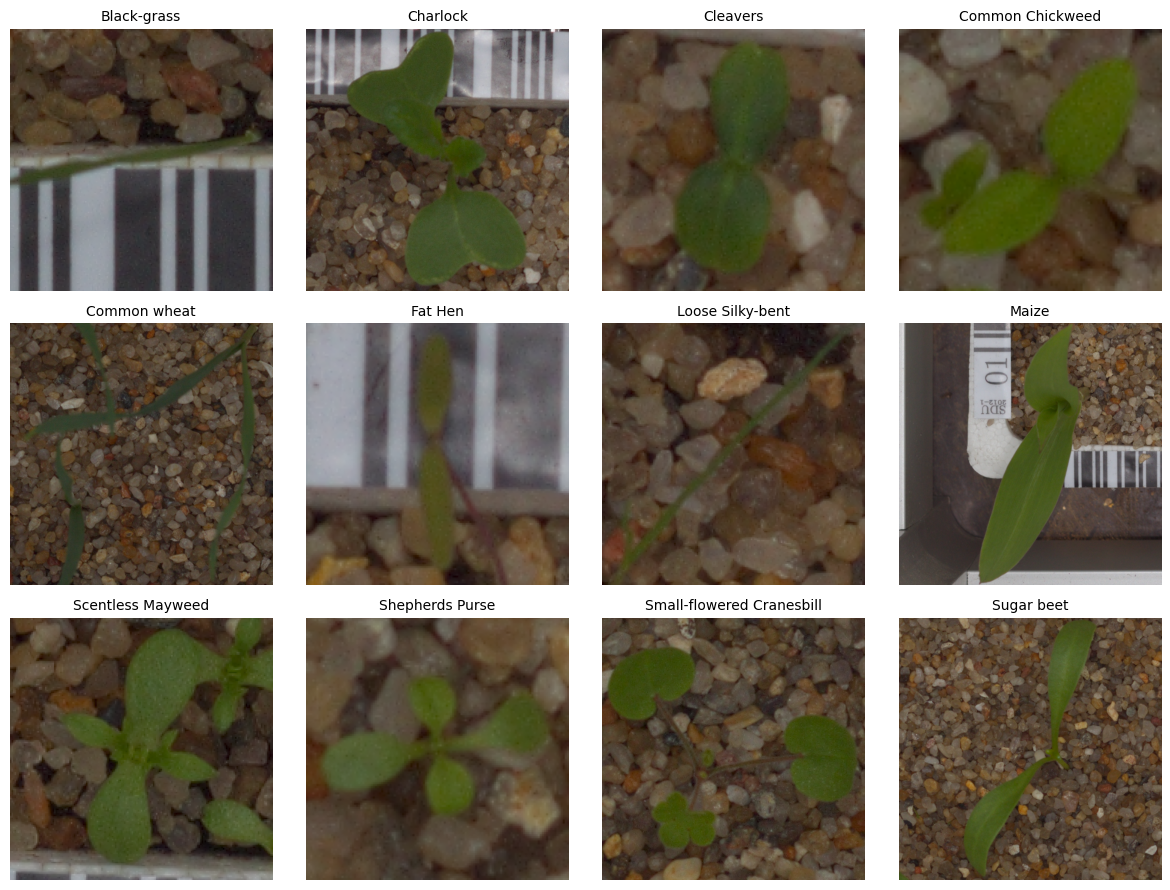

In [15]:
# Class mappings
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Collect one sample image path per class
sample_images = {}
for img_path, label in dataset.samples:
    if label not in sample_images:
        sample_images[label] = img_path
    if len(sample_images) == len(class_to_idx):
        break

# Plot: 3x4 grid
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i, (label, img_path) in enumerate(sample_images.items()):
    image = Image.open(img_path).convert("RGB")
    axes[i].imshow(image)
    axes[i].set_title(idx_to_class[label], fontsize=10)
    axes[i].axis("off")

# Hide unused axes if any
for j in range(len(sample_images), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

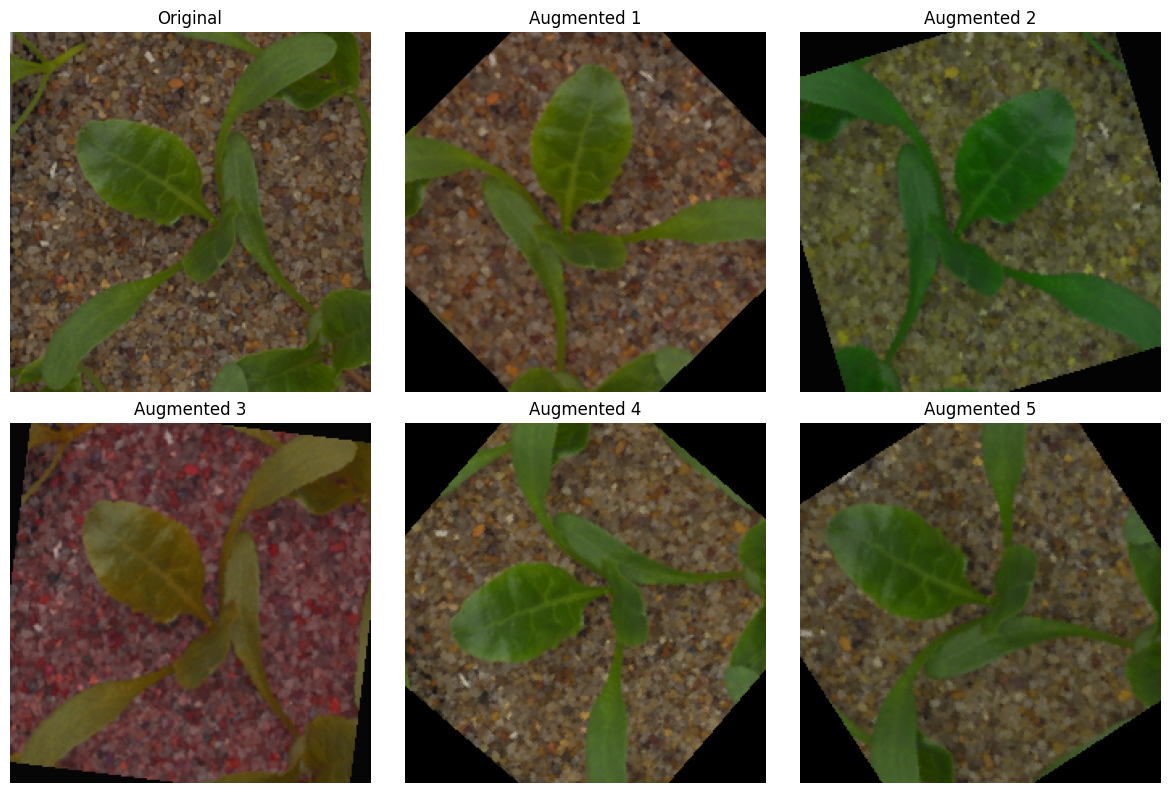

In [34]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import random

sample_img_path, _ = random.choice(datasets.ImageFolder(root=TRAIN_DIR).samples)
original_image = Image.open(sample_img_path).convert("RGB")

# Create a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Show original image
axes[0].imshow(original_image.resize(transform_resize))
axes[0].set_title("Original")
axes[0].axis("off")

# Show 5 augmentations
for i in range(1, 6):
    augmented_tensor = transform(original_image)
    augmented_image = transforms.ToPILImage()(augmented_tensor)
    axes[i].imshow(augmented_image)
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis("off")

# Hide any remaining axes (if fewer than 6 used)
for j in range(6, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()